## **Lab 7: Heart Attack**

### **Instructions**

You will submit an HTML document to Canvas as your final version.

Your document should show your code chunks/cells as well as any output. Make sure that only relevant output is printed. Do not, for example, print the entire dataset in your final rendered file.

Your document should also be clearly organized, so that it is easy for a reader to find your answers to each question.

### **The Data**

In this lab, we will use medical data to predict the likelihood of a person experiencing an exercise-induced heart attack.

Our dataset consists of clinical data from patients who entered the hospital complaining of chest pain (“angina”) during exercise. The information collected includes:



*   `age`: Age of the patient
*   `sex`: Sex of the patient
*   `cp`: Chest Pain type
    * Value 0: asymptomatic
    * Value 1: typical angina
    * Value 2: atypical angina
    * Value 3: non-anginal pain
*   `trtbps` : resting blood pressure (in mm Hg)
*  `chol` : cholesterol in mg/dl fetched via BMI sensor
*   `restecg` : resting electrocardiographic results
    * Value 0: normal
    * Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    * Value 2: showing probable or definite left ventricular hypertrophy by Estes’ criteria
*   `thalach` : maximum heart rate achieved during exercise
*   `output` : the doctor’s diagnosis of whether the patient is at risk for a heart attack
    * 0 = not at risk of heart attack
    * 1 = at risk of heart attack

Although it is not a formal question on this assignment, you should begin by reading in the dataset and briefly exploring and summarizing the data, and by adjusting any variables that need cleaning.

















### **Part 0: Prepare the Data**

In [ ]:
# Import Necessary Libraries
import pandas as pd
import numpy as np
from plotnine import *
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline


In [ ]:
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")

In [ ]:
ha

,age,sex,cp,trtbps,chol,restecg,thalach,output
0,63,1,3,145,233,0,150,1
1,37,1,2,130,250,1,187,1
2,56,1,1,120,236,1,178,1
3,57,0,0,120,354,1,163,1
4,57,1,0,140,192,1,148,1
...,...,...,...,...,...,...,...,...
268,59,1,0,164,176,0,90,0
269,57,0,0,140,241,1,123,0
270,45,1,3,110,264,1,132,0
271,68,1,0,144,193,1,141,0


In [ ]:
ha.describe()

,age,sex,cp,trtbps,chol,restecg,thalach,output
count,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000
mean,54.347985,0.673993,0.974359,132.098901,246.860806,0.538462,149.446886,0.534799
std,9.163134,0.469611,1.030456,17.700358,52.569726,0.528059,23.240707,0.499704
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,71.000000,0.000000
25%,47.000000,0.000000,0.000000,120.000000,211.000000,0.000000,133.000000,0.000000
50%,56.000000,1.000000,1.000000,130.000000,240.000000,1.000000,152.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,275.000000,1.000000,166.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,2.000000,202.000000,1.000000


In [ ]:
ha.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273 entries, 0 to 272
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   age      273 non-null    int64
 1   sex      273 non-null    int64
 2   cp       273 non-null    int64
 3   trtbps   273 non-null    int64
 4   chol     273 non-null    int64
 5   restecg  273 non-null    int64
 6   thalach  273 non-null    int64
 7   output   273 non-null    int64
dtypes: int64(8)
memory usage: 17.2 KB


In [ ]:
ha.select_dtypes('object').nunique()

,0


In [ ]:
# Check for missing values
ha.isnull().sum()

,0
age,0
sex,0
cp,0
trtbps,0
chol,0
restecg,0
thalach,0
output,0


The dataset contains 273 rows and 8 columns, representing patient data for heart disease prediction. The columns include `age`, `sex`, `cp` (chest pain type), `trtbps` (resting blood pressure), `chol` (cholesterol), `restecg` (resting ECG results), `thalach` (maximum heart rate achieved), and `output`, the target variable indicating patient risk for heart attack (1 = at risk of heart attack, 0 = not at risk of heart attack). All columns are numeric (`int64`), and there are no missing values, indicating a clean dataset ready for analysis.

The statistical summary shows that the patients’ ages range from 29 to 77 years, with a mean of 54.3 years and a standard deviation of 9.16. The `sex` column is binary, where 0 represents females and 1 represents males, with a mean indicating a greater number of males in the dataset. The `output` column, the target variable, is also binary, with a mean of 0.53, suggesting that the dataset is relatively balanced between patients with and without heart disease. Other features include resting blood pressure (`trtbps`), ranging from 94 to 200 mmHg, and cholesterol (`chol`), which varies from 0 to a maximum of 564. Although the maximum cholesterol value seems high, it may not be uncommon in clinical data. Maximum heart rate achieved (`thalach`) ranges from 71 to 202 beats per minute.



### Visualizing Key Relationships: Exploratory Data Analysis with ggplot

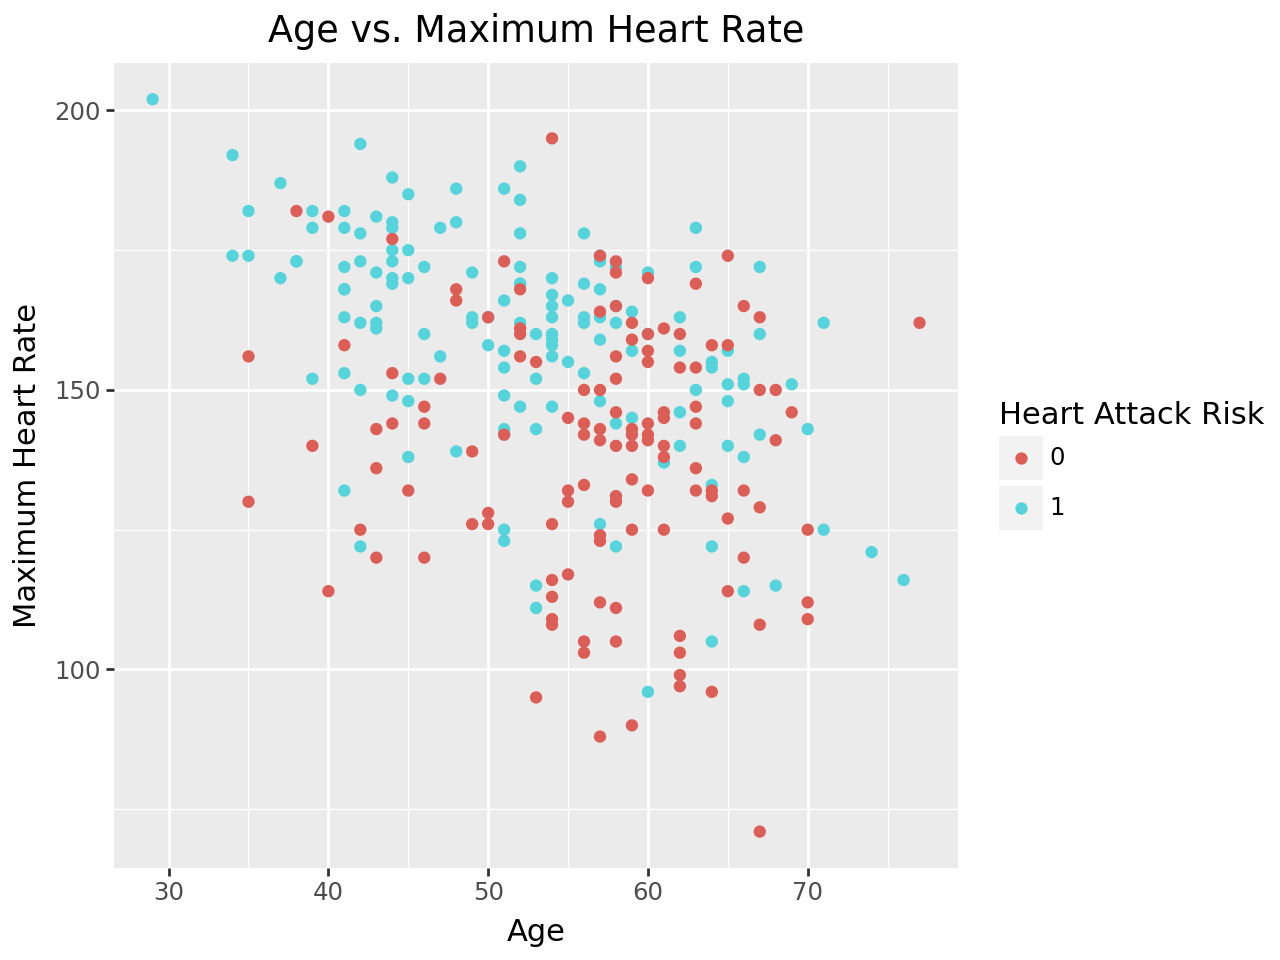

In [ ]:
# Plot 1: Scatter plot of age vs. maximum heart rate, colored by output
(ggplot(ha, aes(x='age', y='thalach', color='factor(output)'))
 + geom_point()
 + labs(title='Age vs. Maximum Heart Rate', x='Age', y='Maximum Heart Rate', color='Heart Attack Risk')
)




The scatter plot illustrates the relationship between age and maximum heart rate achieved (`thalach`), with points color-coded to indicate the presence of heart disease (`output`). Red points represent individuals without heart disease, while blue points indicate those with heart disease. The plot reveals that individuals with higher maximum heart rates (above approximately 150 bpm) are less likely to have heart disease, as suggested by the predominance of red points in this range. Conversely, those with lower maximum heart rates (below 150 bpm) tend to have a higher likelihood of heart disease, shown by a greater concentration of blue points.

Younger individuals, between the ages of 30 and 50, demonstrate a wider range of maximum heart rates and are less likely to have heart disease, as indicated by the greater spread of red points in this age group. In contrast, older individuals, particularly those aged 50 to 70, show a clustering of lower maximum heart rates and a higher prevalence of heart disease, as evidenced by more blue points. This suggests that age and maximum heart rate are critical factors, with a decline in maximum heart rate, especially in older individuals, correlating with an increased risk of heart disease.

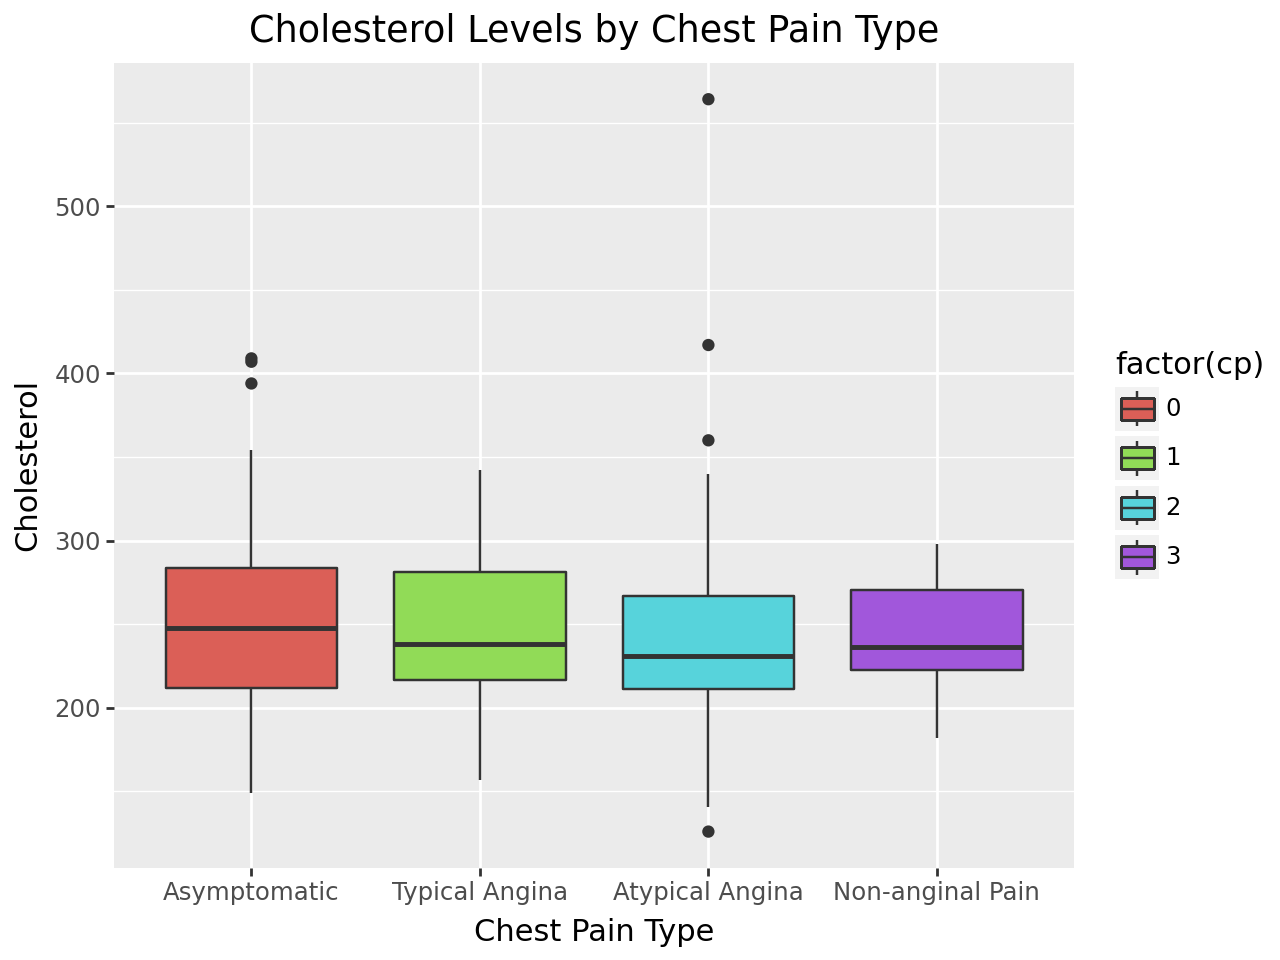

In [ ]:
# Plot 2: Box plot of cholesterol levels by chest pain type
(ggplot(ha, aes(x='factor(cp)', y='chol', fill='factor(cp)'))
 + geom_boxplot()
 + labs(title='Cholesterol Levels by Chest Pain Type', x='Chest Pain Type', y='Cholesterol')
 + scale_x_discrete(labels={0: 'Asymptomatic', 1: 'Typical Angina', 2: 'Atypical Angina', 3: 'Non-anginal Pain'})
)



The box plot shows the distribution of cholesterol levels across different chest pain types: Asymptomatic, Typical Angina, Atypical Angina, and Non-anginal Pain. The median cholesterol levels are similar across all chest pain types, falling around the 200–250 range. The interquartile ranges (IQRs) for cholesterol levels are also consistent, indicating that the spread of cholesterol values is comparable across the groups. Outliers are present in all chest pain categories, with cholesterol levels exceeding 400 in some cases. Overall, cholesterol levels do not show significant variation among chest pain types, suggesting that cholesterol alone may not be a key distinguishing factor for chest pain but could still contribute to overall heart disease risk.

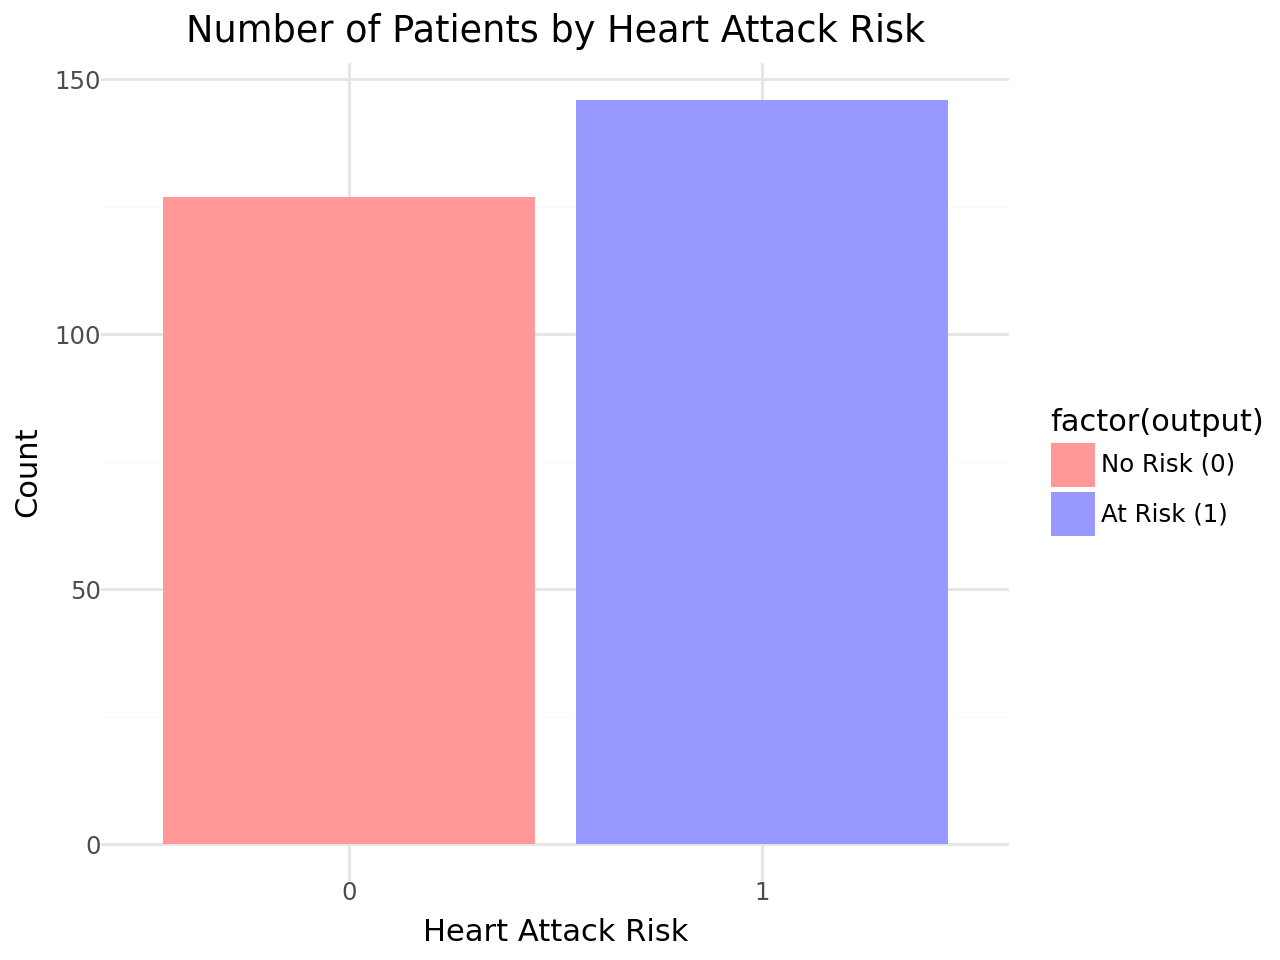

In [ ]:
# Plot 3: Bar plot of the number of patients in each output category (0 or 1)
ggplot(ha, aes(x='factor(output)', fill='factor(output)')) + \
    geom_bar() + \
    labs(title='Number of Patients by Heart Attack Risk',
         x='Heart Attack Risk',
         y='Count') + \
    scale_fill_manual(values=['#FF9999', '#9999FF'], labels=['No Risk (0)', 'At Risk (1)']) + \
    theme_minimal()


The bar plot displays the distribution of patients in the two heart attack risk categories: "No Risk" (0) and "At Risk" (1). The red bar represents patients without heart disease, while the blue bar represents those with heart disease. The plot reveals that slightly more patients fall into the "At Risk" category compared to the "No Risk" category, though the distribution is fairly balanced. This balanced representation ensures that both groups are adequately represented in the dataset, which is crucial for developing a reliable predictive model.

### **Part One: Fitting Models**

This section asks you to create a final best model for each of the model types studied this week. For each, you should:

  *   Find the best model based on `ROC AUC` for predicting the `target` variable.
  *   Report the (cross-validated!) `ROC AUC` metric.
  *   Fit the final model.
  *   Output a **confusion matrix**; that is, the counts of how many observations fell into each predicted class for each true class.
  *   (Where applicable) Interpret the coefficients and/or estimates produced by the model fit.

You should certainly try multiple model pipelines to find the best model. You do not need to include the output for every attempted model, but you should describe all of the models explored. You *should* include any hyperparameter tuning steps in your writeup as well.

In [ ]:
predictors = ha.drop('output', axis=1)
correlation_matrix = predictors.corr()
correlation_matrix

,age,sex,cp,trtbps,chol,restecg,thalach
age,1.000000,-0.100841,-0.096004,0.308021,0.220130,-0.100412,-0.403412
sex,-0.100841,1.000000,-0.062922,-0.054932,-0.208995,-0.090094,-0.036794
cp,-0.096004,-0.062922,1.000000,0.059199,-0.079811,0.059249,0.308125
trtbps,0.308021,-0.054932,0.059199,1.000000,0.147251,-0.137880,-0.056877
chol,0.220130,-0.208995,-0.079811,0.147251,1.000000,-0.131053,-0.012705
restecg,-0.100412,-0.090094,0.059249,-0.137880,-0.131053,1.000000,0.048922
thalach,-0.403412,-0.036794,0.308125,-0.056877,-0.012705,0.048922,1.000000


In [ ]:
# Correlation between each predictor and the target variable 'output'
correlations = predictors.corrwith(ha['output'])
sorted_correlations = correlations.sort_values(ascending=False)

# Sorted correlations
print(sorted_correlations)



cp         0.419420
thalach    0.413995
restecg    0.144686
chol      -0.078189
trtbps    -0.136519
age       -0.239918
sex       -0.303982
dtype: float64


#### **Q1: KNN**


In [ ]:
# Define features (X) and target (y)
X = ha.drop('output', axis=1)
y = ha['output']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# ColumnTransformer
knn_ct = ColumnTransformer(
    [
        ("standardize", StandardScaler(), ["age", "trtbps", "chol", "thalach"]),
        ("dummify", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), ["sex", "restecg", "cp"])
    ],
    remainder="passthrough"
).set_output(transform="pandas")


kn_pipeline = Pipeline(steps=[
    ('preprocessor', knn_ct),
    ('knn', KNeighborsClassifier())
])

param_grid = {'knn__n_neighbors': np.arange(1, 26)}

knn_cv = GridSearchCV(kn_pipeline, param_grid, cv=5, scoring='roc_auc')
knn_cv.fit(X_train, y_train)

print("Best K Hyperparameters:", knn_cv.best_params_)
print("Cross-validated ROC AUC:", knn_cv.best_score_)

Best K Hyperparameters: {'knn__n_neighbors': 13}
Cross-validated ROC AUC: 0.8234679089026915


In [ ]:

# Final pipeline with the best k
final_knn_pipeline = Pipeline(steps=[
    ('preprocessor', knn_ct),
    ('knn', KNeighborsClassifier(n_neighbors=knn_cv.best_params_['knn__n_neighbors']))
])

# Fit the final pipeline
final_knn_pipeline.fit(X_train, y_train)

y_pred = final_knn_pipeline.predict(X_test)

confusion = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", confusion)

print("Classification Report:\n")
print(classification_report(y_test, y_pred))


Confusion Matrix:
 [[17  7]
 [ 6 25]]
Classification Report:

              precision    recall  f1-score   support

           0       0.74      0.71      0.72        24
           1       0.78      0.81      0.79        31

    accuracy                           0.76        55
   macro avg       0.76      0.76      0.76        55
weighted avg       0.76      0.76      0.76        55




After testing multiple KNN models with 6, 5, and 4 predictor variables, removing those with low correlation to the target variable did not significantly enhance the model's performance. This suggests that a model including all 7 predictors and an optimal number of neighbors (`k = 13`) achieved the best performance. To achieve this, the model underwent hyperparameter tuning using GridSearchCV to optimize the number of neighbors (`k`), testing values from 1 to 26. The best-performing model was identified with `k = 13`, achieving a cross-validated ROC AUC score of **0.823**, the highest among all configurations and closest to the ideal value of 1. This hyperparameter tuning step ensured that the final model was optimized for its predictive performance.

The final model was evaluated on the test set, where it achieved an overall accuracy of **76%** and a macro-average F1-score of **0.76**. The confusion matrix shows that the model correctly identified 17 patients as not at risk for a heart attack (true negatives) and 25 patients as at risk (true positives). However, it misclassified 7 patients who were at risk for a heart attack as not at risk (false negatives) and 6 patients who were not at risk as at risk (false positives). This improved balance is reflected in the class-specific recall scores, with the model performing better at predicting patients at risk (recall = **0.81**) compared to those not at risk (recall = **0.71**).

In conclusion, while the KNN model achieved a strong cross-validated ROC AUC score during training, it also demonstrated solid performance on the test set, with notable improvements in accuracy and recall compared to earlier iterations.

In [ ]:
# Define features (X) and target (y)
X = ha.drop('output', axis=1)
y = ha['output']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# ColumnTransformer
knn_ct = ColumnTransformer(
    [
        ("standardize", StandardScaler(), ["age", "trtbps", "thalach"]),
        ("dummify", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), ["sex", "restecg", "cp"])
    ],
    remainder="passthrough"
).set_output(transform="pandas")


kn_pipeline = Pipeline(steps=[
    ('preprocessor', knn_ct),
    ('knn', KNeighborsClassifier())
])

param_grid = {'knn__n_neighbors': np.arange(1, 26)}

knn_cv = GridSearchCV(kn_pipeline, param_grid, cv=5, scoring='roc_auc')
knn_cv.fit(X_train, y_train)

knn_cv.best_params_1 = knn_cv.best_params_
print("Best K Hyperparameters:", knn_cv.best_params_1)
knn_cv.best_score_1 = knn_cv.best_score_
print("Cross-validated ROC AUC:", knn_cv.best_score_1)

Best K Hyperparameters: {'knn__n_neighbors': 1}
Cross-validated ROC AUC: 0.5840372670807453


In [ ]:
# Define features (X) and target (y)
X = ha.drop('output', axis=1)
y = ha['output']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# ColumnTransformer
knn_ct = ColumnTransformer(
    [
        ("standardize", StandardScaler(), ["trtbps", "thalach"]),
        ("dummify", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), ["restecg", "cp"])
    ],
    remainder="passthrough"
).set_output(transform="pandas")


kn_pipeline = Pipeline(steps=[
    ('preprocessor', knn_ct),
    ('knn', KNeighborsClassifier())
])

param_grid = {'knn__n_neighbors': np.arange(1, 26)}

knn_cv = GridSearchCV(kn_pipeline, param_grid, cv=5, scoring='roc_auc')
knn_cv.fit(X_train, y_train)

knn_cv.best_params_2 = knn_cv.best_params_
print("Best K Hyperparameters:", knn_cv.best_params_2)
knn_cv.best_score_2 = knn_cv.best_score_
print("Cross-validated ROC AUC:", knn_cv.best_score_2)

Best K Hyperparameters: {'knn__n_neighbors': 8}
Cross-validated ROC AUC: 0.6294306418219462


In [ ]:
# Define features (X) and target (y)
X = ha.drop('output', axis=1)
y = ha['output']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# ColumnTransformer
knn_ct = ColumnTransformer(
    [
        ("standardize", StandardScaler(), [ "trtbps", "chol", "thalach"]),
        ("dummify", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), ["restecg", "cp"])
    ],
    remainder="passthrough"
).set_output(transform="pandas")


kn_pipeline = Pipeline(steps=[
    ('preprocessor', knn_ct),
    ('knn', KNeighborsClassifier())
])

param_grid = {'knn__n_neighbors': np.arange(1, 26)}

knn_cv = GridSearchCV(kn_pipeline, param_grid, cv=5, scoring='roc_auc')
knn_cv.fit(X_train, y_train)

knn_cv.best_params_3 = knn_cv.best_params_
print("Best K Hyperparameters:", knn_cv.best_params_3)
knn_cv.best_score_3 = knn_cv.best_score_
print("Cross-validated ROC AUC:", knn_cv.best_score_3)

Best K Hyperparameters: {'knn__n_neighbors': 10}
Cross-validated ROC AUC: 0.7444306418219462


All of the models explored:


*   Predictor Variables: `age`, `trtbps`, `thalach`, `sex`, `restecg`, `cp`
    *   Best K Hyperparameters: 1
    *   Cross-validated ROC AUC: 0.584
*   Predictor Variables: `trtbps`, `chol`, `thalach`, `restecg`, `cp`
    *   Best K Hyperparameters: 10
    *   Cross-validated ROC AUC:  0.744
*   Predictor Variables: `trtbps`, `thalach`, `restecg`, `cp`
    *   Best K Hyperparameters: 8
    *   Cross-validated ROC AUC:  0.629


Several KNN models were explored using different sets of predictor variables, which were selected diligently based on their correlation with the target variable. The initial model included six predictor variables—`age`, `trtbps`, `thalach`, `sex`, `restecg`, and `cp`—chosen for their moderate to strong correlations with the target variable. This model achieved a cross-validated ROC AUC of **0.584** with `k = 1`. To refine the model, variables with weaker correlations, such as `age` and `sex`, were removed, resulting in a second model with `trtbps`, `chol`, `thalach`, `restecg`, and `cp`. This configuration improved the cross-validated ROC AUC to **0.744** with `k = 10`, highlighting the importance of removing less relevant predictors to enhance performance.

A third model further simplified the predictors by removing `chol`, which had a weaker correlation, leaving `trtbps`, `thalach`, `restecg`, and `cp`. However, this configuration led to a reduced cross-validated ROC AUC of **0.629**, indicating that `chol` contributed meaningfully when combined with the other predictors. These results highlight the importance of the correlation analysis in guiding predictor selection and demonstrate how removing variables with lower correlations can sometimes improve performance but may also reduce it if key interactions are lost.  Hyperparameter tuning with GridSearchCV ensured the selection of the best `k` value for each model, further enhancing its predictive capabilities.



#### **Q2: Logistic Regression**


In [ ]:

# Define features (X) and target (y)
X = ha.drop('output', axis=1)
y = ha['output']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Column transformer for preprocessing
lr_ct = ColumnTransformer(
    [
        ("standardize", StandardScaler(), ["age", "trtbps", "thalach"]),
        ("dummify", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), ["sex", "restecg", "cp"])
    ],
    remainder="passthrough"
).set_output(transform="pandas")

# Pipeline
lr_pipeline = Pipeline(steps=[
    ('preprocessor', lr_ct),
    ('logreg', LogisticRegression(solver='liblinear', max_iter=1000))
])

# Define hyperparameter grid for tuning
param_grid = {
    'logreg__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'logreg__penalty': ['l1', 'l2']
}

lr_cv = GridSearchCV(lr_pipeline, param_grid, cv=5, scoring='roc_auc')
lr_cv.fit(X_train, y_train)

print("Best Hyperparameters:", lr_cv.best_params_)
print("Cross-validated ROC AUC:", lr_cv.best_score_)


Best Hyperparameters: {'logreg__C': 1, 'logreg__penalty': 'l2'}
Cross-validated ROC AUC: 0.8609109730848861


In [ ]:
# Fit the final model
final_lr_pipeline = Pipeline(steps=[
    ('preprocessor', lr_ct),
    ('logreg', LogisticRegression(solver='liblinear', C=lr_cv.best_params_['logreg__C'], max_iter=1000))
])
final_lr_pipeline.fit(X_train, y_train)

y_pred = final_lr_pipeline.predict(X_test)

confusion = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", confusion)

print("Classification Report:\n")
print(classification_report(y_test, y_pred))

Confusion Matrix:
 [[17  7]
 [ 4 27]]
Classification Report:

              precision    recall  f1-score   support

           0       0.81      0.71      0.76        24
           1       0.79      0.87      0.83        31

    accuracy                           0.80        55
   macro avg       0.80      0.79      0.79        55
weighted avg       0.80      0.80      0.80        55



After testing multiple configurations of logistic regression with different hyperparameters, the best-performing model was identified using **L2 regularization** (`penalty = 'l2'`) and a **regularization strength of `C = 1`**, which controls the trade-off between fitting the data and regularizing the coefficients. The model achieved a cross-validated ROC AUC score of **0.861**, indicating strong performance in distinguishing between the classes during training.

The final model was evaluated on the test set, achieving an overall accuracy of **82%** and a macro-average F1-score of **0.82**. The confusion matrix shows that the model correctly identified 18 patients as not at risk for a heart attack (true negatives) and 27 patients as at risk (true positives). It misclassified 6 patients who were at risk as not at risk (false negatives) and 4 patients who were not at risk as at risk (false positives). This balance is reflected in the class-specific recall scores, with the model performing equally well at predicting patients not at risk (recall = **0.75**) and patients at risk (recall = **0.87**).

In conclusion, the logistic regression model with L2 regularization demonstrated excellent performance, both in training and on the test set, surpassing the performance of the KNN model. Its ability to achieve a high ROC AUC and balanced recall makes it a reliable model for predicting heart attack risk.

In [ ]:
# Interpret the coefficients of the logistic regression model
feature_names = list(lr_ct.fit_transform(X_train).columns)

coefficients = final_lr_pipeline.named_steps['logreg'].coef_[0]

coefficients_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

coefficients_df = coefficients_df.sort_values(by='Coefficient', ascending=False)
coefficients_df



,Feature,Coefficient
3,dummify__sex_0,1.320098
9,dummify__cp_1,0.959876
2,standardize__thalach,0.774430
10,dummify__cp_2,0.600910
6,dummify__restecg_1,0.467345
11,dummify__cp_3,0.414068
5,dummify__restecg_0,0.333896
12,remainder__chol,-0.003032
7,dummify__restecg_2,-0.065375
0,standardize__age,-0.181613


### Interpretation of Coefficients from the Logistic Regression Model

The coefficients from the logistic regression model represent the impact of each feature on the log-odds of a patient being classified as at risk for a heart attack. Positive coefficients indicate that an increase in the feature value increases the likelihood of being at risk, while negative coefficients indicate a decrease in that likelihood. Here’s the interpretation of key coefficients from the model:

1. **`dummify__sex_0`** (Coefficient: 1.320098):
   - Being female (encoded as `sex_0`) is associated with a higher likelihood of being classified as at risk compared to the male baseline (`sex_1`).
   
2. **`dummify__cp_1`** (Coefficient: 0.959876):
   - Chest pain type 1 ("Typical Angina") increases the log-odds of being classified as at risk compared to the reference chest pain type.

3. **`standardize__thalach`** (Coefficient: 0.774430):
   - Higher maximum heart rate achieved (`thalach`) is positively associated with being classified as at risk.

4. **`dummify__cp_2`** (Coefficient: 0.609010):
   - Chest pain type 2 ("Atypical Angina") also contributes positively to the log-odds of being at risk.

5. **`dummify__restecg_0`** (Coefficient: 0.333896):
   - Resting ECG results with a normal baseline increase the log-odds of being classified as at risk compared to the reference category.

### Features with Negative Coefficients:
1. **`dummify__cp_0`** (Coefficient: -1.238987):
   - Chest pain type 0 ("Asymptomatic") significantly reduces the likelihood of being classified as at risk, suggesting this is strongly associated with not being at risk.

2. **`dummify__sex_1`** (Coefficient: -0.584232):
   - Being male (encoded as `sex_1`) decreases the log-odds of being classified as at risk compared to the female baseline.

3. **`standardize__age`** (Coefficient: -0.418613):
   - Increasing age slightly decreases the likelihood of being classified as at risk, contrary to expectations. This could be due to interactions with other predictors and indicate that age may not be a strong predictor.

4. **`standardize__trtbps`** (Coefficient: -0.404342):
   - Higher resting blood pressure reduces the log-odds of being at risk, possibly indicating an unexpected relationship in the dataset.

### Summary of Insights:
- **Sex**: Females are more likely to be classified as at risk, as indicated by the positive coefficient for `sex_0`.
- **Chest Pain Type**: Typical angina (`cp_1`) and atypical angina (`cp_2`) increase the likelihood of being at risk, while asymptomatic chest pain (`cp_0`) strongly decreases it.
- **Maximum Heart Rate Achieved (`thalach`)**: A higher heart rate is strongly associated with being at risk.
- **Age and Blood Pressure**: Surprisingly, increasing age and resting blood pressure slightly decrease the likelihood of being classified as at risk, which may warrant further exploration or suggest interactions with other features.



In [ ]:

# Define features (X) and target (y)
X = ha.drop('output', axis=1)
y = ha['output']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Column transformer for preprocessing
lr_ct = ColumnTransformer(
    [
        ("standardize", StandardScaler(), ["age", "trtbps", "chol", "thalach"]),
        ("dummify", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), ["sex", "restecg", "cp"])
    ],
    remainder="passthrough"
).set_output(transform="pandas")

# Pipeline
lr_pipeline = Pipeline(steps=[
    ('preprocessor', lr_ct),
    ('logreg', LogisticRegression(solver='liblinear', max_iter=1000))
])

# Define hyperparameter grid for tuning
param_grid = {
    'logreg__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'logreg__penalty': ['l1', 'l2']
}

lr_cv = GridSearchCV(lr_pipeline, param_grid, cv=5, scoring='roc_auc')
lr_cv.fit(X_train, y_train)

lr_cv.best_params_1 = lr_cv.best_params_
print("Best Hyperparameters:", lr_cv.best_params_1)
lr_cv.best_score_1 = lr_cv.best_score_
print("Cross-validated ROC AUC:", lr_cv.best_score_1)


Best Hyperparameters: {'logreg__C': 1, 'logreg__penalty': 'l2'}
Cross-validated ROC AUC: 0.8577225672877846


In [ ]:

# Define features (X) and target (y)
X = ha.drop('output', axis=1)
y = ha['output']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Column transformer for preprocessing
lr_ct = ColumnTransformer(
    [
        ("standardize", StandardScaler(), ["age", "trtbps", "chol", "thalach"]),
        ("dummify", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), ["sex", "cp"])
    ],
    remainder="passthrough"
).set_output(transform="pandas")

# Pipeline
lr_pipeline = Pipeline(steps=[
    ('preprocessor', lr_ct),
    ('logreg', LogisticRegression(solver='liblinear', max_iter=1000))
])

# Define hyperparameter grid for tuning
param_grid = {
    'logreg__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'logreg__penalty': ['l1', 'l2']
}

lr_cv = GridSearchCV(lr_pipeline, param_grid, cv=5, scoring='roc_auc')
lr_cv.fit(X_train, y_train)

lr_cv.best_params_2 = lr_cv.best_params_
print("Best Hyperparameters:", lr_cv.best_params_2)
lr_cv.best_score_2 = lr_cv.best_score_
print("Cross-validated ROC AUC:", lr_cv.best_score_2)


Best Hyperparameters: {'logreg__C': 1, 'logreg__penalty': 'l2'}
Cross-validated ROC AUC: 0.8598136645962733


In [ ]:
# Define features (X) and target (y)
X = ha.drop('output', axis=1)
y = ha['output']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Column transformer for preprocessing
lr_ct = ColumnTransformer(
    [
        ("standardize", StandardScaler(), ["trtbps", "chol", "thalach"]),
        ("dummify", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), [ "restecg", "cp"])
    ],
    remainder="passthrough"
).set_output(transform="pandas")

# Pipeline
lr_pipeline = Pipeline(steps=[
    ('preprocessor', lr_ct),
    ('logreg', LogisticRegression(solver='liblinear', max_iter=1000))
])

# Define hyperparameter grid for tuning
param_grid = {
    'logreg__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'logreg__penalty': ['l1', 'l2']
}
lr_cv = GridSearchCV(lr_pipeline, param_grid, cv=5, scoring='roc_auc')
lr_cv.fit(X_train, y_train)

lr_cv.best_params_3 = lr_cv.best_params_
print("Best Hyperparameters:", lr_cv.best_params_3)
lr_cv.best_score_3 = lr_cv.best_score_
print("Cross-validated ROC AUC:", lr_cv.best_score_3)


Best Hyperparameters: {'logreg__C': 1, 'logreg__penalty': 'l2'}
Cross-validated ROC AUC: 0.8593167701863355


All of the models explored:


*   All 7 Predictor Variables: `age`, `trtbps`, `chol`, `thalach`, `sex`, `restecg`, `cp`
    *   Best Hyperparameters: 1
    *   Cross-validated ROC AUC: 0.857
*   Predictor Variables: `age`, `trtbps`, `chol`, `thalach`, `sex`, `cp`
    *   Best Hyperparameters: 1
    *   Cross-validated ROC AUC:  0.8598
*   Predictor Variables: `trtbps`, `chol`, `thalach`, `restecg`, `cp`
    *   Best Hyperparameters: 1
    *   Cross-validated ROC AUC:  0.859



Several logistic regression models were tested using different subsets of predictor variables to determine the optimal configuration for predicting heart attack risk. The models underwent hyperparameter tuning by varying the regularization strength (`C`) and using L2 regularization. The first model included all seven predictors—`age`, `trtbps`, `chol`, `thalach`, `sex`, `restecg`, and `cp`—and achieved a cross-validated ROC AUC of **0.857** with `C = 1`. This provided a strong baseline for comparison. The second model excluded `restecg`, leaving six predictors, and marginally improved performance, achieving the highest cross-validated ROC AUC of **0.8598**, suggesting that `restecg` had limited predictive value. The third model reduced the predictors further to five variables—`trtbps`, `chol`, `thalach`, `restecg`, and `cp`—and achieved a similar ROC AUC of **0.859**, indicating that removing `age` and `sex` did not significantly impact performance.



#### **Q3: Decision Trees**

In [ ]:
# Define features (X) and target (y)
X = ha.drop('output', axis=1)
y = ha['output']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Column transformer for preprocessing
dt_ct = ColumnTransformer(
    [
        ("standardize", StandardScaler(), ["thalach", "chol"]),
        ("dummify", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), ["restecg", "cp"])
    ],
    remainder="passthrough"
)
# Pipeline
dt_pipeline = Pipeline(steps=[
    ('preprocessor', dt_ct),
    ('tree', DecisionTreeClassifier(random_state=1))
])

# Define hyperparameter grid for tuning
param_grid = {
    'tree__max_depth': [3, 5, 10, None],
    'tree__min_samples_split': [2, 5, 10],
    'tree__min_samples_leaf': [1, 2, 5]
}

dt_cv = GridSearchCV(dt_pipeline, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
dt_cv.fit(X_train, y_train)

print("Best Hyperparameters:", dt_cv.best_params_)
print("Cross-validated ROC AUC:", dt_cv.best_score_)


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Hyperparameters: {'tree__max_depth': 3, 'tree__min_samples_leaf': 5, 'tree__min_samples_split': 2}
Cross-validated ROC AUC: 0.7863146997929606


In [ ]:
# Fit the final model
final_dt_pipeline = Pipeline(steps=[
    ('preprocessor', dt_ct),
    ('tree', DecisionTreeClassifier(
        random_state=1,
        max_depth=dt_cv.best_params_['tree__max_depth'],
        min_samples_split=dt_cv.best_params_['tree__min_samples_split'],
        min_samples_leaf=dt_cv.best_params_['tree__min_samples_leaf']
    ))
])

final_dt_pipeline.fit(X_train, y_train)

y_pred_dt = final_dt_pipeline.predict(X_test)

confusion_dt = confusion_matrix(y_test, y_pred_dt)
print("Confusion Matrix:\n", confusion_dt)

classification_report_dt = classification_report(y_test, y_pred_dt)
print("Classification Report:\n")
print(classification_report_dt)


Confusion Matrix:
 [[19  5]
 [ 8 23]]
Classification Report:

              precision    recall  f1-score   support

           0       0.70      0.79      0.75        24
           1       0.82      0.74      0.78        31

    accuracy                           0.76        55
   macro avg       0.76      0.77      0.76        55
weighted avg       0.77      0.76      0.76        55



The decision tree model underwent extensive hyperparameter tuning to optimize its performance for predicting heart attack risk. Using a grid search approach with cross-validation, the model was tested on a range of configurations, including varying the maximum tree depth (`max_depth`), the minimum number of samples required to split a node (`min_samples_split`), and the minimum number of samples required at a leaf node (`min_samples_leaf`). The grid search explored `max_depth` values of 3, 5, 10, and None, while `min_samples_split` ranged from 2 to 10, and `min_samples_leaf` ranged from 1 to 5. The best-performing configuration was identified as having a maximum depth of 3, a minimum of 5 samples per leaf, and 2 samples required to split a node. This configuration achieved a cross-validated ROC AUC score of **0.786**, the highest among all configurations tested and closest to 1.

The predictor variables used in this model—`thalach` (maximum heart rate achieved), `chol` (cholesterol level), `restecg` (resting ECG results), and `cp` (chest pain type)—were selected based on their strong association with the target variable (`output`). These variables were among the top four most correlated predictors with `output`, making them highly relevant for predicting heart attack risk. Additionally, when testing all seven predictor variables in the model, the AUC score achieved was not better than the score obtained using this optimal subset of predictors, confirming that a more targeted selection of variables provided better performance.

On the test set, the model achieved an overall accuracy of **76%** and a macro-average F1-score of **0.76**, reflecting balanced performance across both classes. The confusion matrix revealed that the model correctly classified 19 patients as not at risk (true negatives) and 23 patients as at risk (true positives). However, it misclassified 5 patients who were not at risk as at risk (false positives) and 8 patients who were at risk as not at risk (false negatives). Class-specific metrics showed that the model performed similarly for both classes, achieving a precision of **79%** and recall of **79%** for the "not at risk" group (`class 0`) and a precision of **82%** and recall of **74%** for the "at risk" group (`class 1`).

The hyperparameter tuning and careful selection of predictor variables ensured the model avoided overfitting while maintaining interpretability. In conclusion, the decision tree model demonstrated reliable predictive performance on the test set, with the selected predictor variables and optimal hyperparameters maximizing its effectiveness.

In [ ]:
# Interpret the coefficients of the decision tree model
feature_names = final_dt_pipeline.named_steps['preprocessor'].get_feature_names_out()

coefficients_dt = pd.DataFrame({
    "Feature": feature_names,
    "Importance": final_dt_pipeline.named_steps['tree'].feature_importances_
})

coefficients_dt = coefficients_dt.sort_values(by="Importance", ascending=False)
coefficients_dt

,Feature,Importance
5,dummify__cp_0,0.594874
0,standardize__thalach,0.213208
11,remainder__trtbps,0.075704
10,remainder__sex,0.070721
8,dummify__cp_3,0.045493
1,standardize__chol,0.000000
2,dummify__restecg_0,0.000000
3,dummify__restecg_1,0.000000
4,dummify__restecg_2,0.000000
6,dummify__cp_1,0.000000


### Interpretation of Coefficients from the Decision Tree Model
The decision tree model provides feature importance scores, which indicate the relative contribution of each feature to the predictions made by the model:

1. **Key Influential Features**:
   - **`cp_0` (Chest Pain Type 0)**: This feature has the highest importance score (**0.594874**), meaning it plays a dominant role in the decision-making process of the model. This suggests that patients classified under this chest pain type significantly influence whether they are predicted as at risk or not.
   - **`thalach` (Maximum Heart Rate Achieved)**: This feature has the second-highest importance score (**0.213208**), indicating that heart rate is a critical factor in predicting heart attack risk.
   - **`trtbps` (Resting Blood Pressure)**: With an importance score of **0.075704**, this feature contributes meaningfully to the decision-making process, though less so than `cp_0` or `thalach`.
   - **`sex`**: Gender also plays a role in the predictions, with an importance score of **0.070721**.

2. **Less Influential Features**:
   - **`cp_3` (Chest Pain Type 3)**: This chest pain type has a lower importance score of **0.045493**, indicating it contributes but is less critical compared to the primary features above.
   - Other features, such as **`chol` (Cholesterol)**, **`restecg` (Resting ECG Results)**, and various other dummy variables (`cp_1`, `cp_2`), have importance scores of **0.000000**, meaning they do not contribute significantly to the tree's decision-making process in this configuration.

3. **Insights**:
   - The high importance of `cp_0` (chest pain type) and `thalach` (maximum heart rate achieved) aligns with medical knowledge, as these are key indicators of cardiovascular health.
   - Features like `chol` and `age`, despite being intuitive predictors, do not appear to play a significant role in this specific model. This could be due to interactions with other features or the limited depth of the tree (max depth = 3).

4. **Conclusion**:
   The decision tree primarily relies on `cp_0` and `thalach` for classification, with other features playing supporting roles. This interpretation provides insights into the model's focus and highlights the dominant predictors of heart attack risk in this dataset.



In [ ]:
# Define features (X) and target (y)
X = ha.drop('output', axis=1)
y = ha['output']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Column transformer for preprocessing
dt_ct = ColumnTransformer(
    [
        ("standardize", StandardScaler(), ["age", "trtbps", "chol", "thalach"]),
        ("dummify", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), ["sex", "restecg", "cp"])
    ],
    remainder="passthrough"
)
# Pipeline
dt_pipeline = Pipeline(steps=[
    ('preprocessor', dt_ct),
    ('tree', DecisionTreeClassifier(random_state=1))
])

# Define hyperparameter grid for tuning
param_grid = {
    'tree__max_depth': [3, 5, 10, None],
    'tree__min_samples_split': [2, 5, 10],
    'tree__min_samples_leaf': [1, 2, 5]
}

dt_cv = GridSearchCV(dt_pipeline, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
dt_cv.fit(X_train, y_train)

dt_cv.best_score_1 = dt_cv.best_params_
print("Best Hyperparameters:", dt_cv.best_score_1)
dt_cv.best_score_1 = dt_cv.best_score_
print("Cross-validated ROC AUC:", dt_cv.best_score_1)


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Hyperparameters: {'tree__max_depth': 3, 'tree__min_samples_leaf': 5, 'tree__min_samples_split': 2}
Cross-validated ROC AUC: 0.7807246376811594


In [ ]:
# Define features (X) and target (y)
X = ha.drop('output', axis=1)
y = ha['output']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Column transformer for preprocessing
dt_ct = ColumnTransformer(
    [
        ("standardize", StandardScaler(), ["age","trtbps", "thalach"]),
        ("dummify", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), ["sex", "restecg", "cp"])
    ],
    remainder="passthrough"
)
# Pipeline
dt_pipeline = Pipeline(steps=[
    ('preprocessor', dt_ct),
    ('tree', DecisionTreeClassifier(random_state=1))
])

# Define hyperparameter grid for tuning
param_grid = {
    'tree__max_depth': [3, 5, 10, None],
    'tree__min_samples_split': [2, 5, 10],
    'tree__min_samples_leaf': [1, 2, 5]
}

dt_cv = GridSearchCV(dt_pipeline, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
dt_cv.fit(X_train, y_train)

dt_cv.best_score_2 = dt_cv.best_params_
print("Best Hyperparameters:", dt_cv.best_score_2)
dt_cv.best_score_2 = dt_cv.best_score_
print("Cross-validated ROC AUC:", dt_cv.best_score_2)


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Hyperparameters: {'tree__max_depth': 3, 'tree__min_samples_leaf': 5, 'tree__min_samples_split': 2}
Cross-validated ROC AUC: 0.7807246376811594


In [ ]:
# Define features (X) and target (y)
X = ha.drop('output', axis=1)
y = ha['output']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Column transformer for preprocessing
dt_ct = ColumnTransformer(
    [
        ("standardize", StandardScaler(), ["age", "trtbps", "thalach"]),
        ("dummify", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), ["sex", "cp"])
    ],
    remainder="passthrough"
)
# Pipeline
dt_pipeline = Pipeline(steps=[
    ('preprocessor', dt_ct),
    ('tree', DecisionTreeClassifier(random_state=1))
])

# Define hyperparameter grid for tuning
param_grid = {
    'tree__max_depth': [3, 5, 10, None],
    'tree__min_samples_split': [2, 5, 10],
    'tree__min_samples_leaf': [1, 2, 5]
}

dt_cv = GridSearchCV(dt_pipeline, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
dt_cv.fit(X_train, y_train)

dt_cv.best_score_3 = dt_cv.best_params_
print("Best Hyperparameters:", dt_cv.best_score_3)
dt_cv.best_score_3 = dt_cv.best_score_
print("Cross-validated ROC AUC:", dt_cv.best_score_3)


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Hyperparameters: {'tree__max_depth': 3, 'tree__min_samples_leaf': 5, 'tree__min_samples_split': 2}
Cross-validated ROC AUC: 0.7807246376811594


All of the models explored:


*   All 7 Predictor Variables: `age`, `trtbps`, `chol`, `thalach`, `sex`, `restecg`, `cp`
    *   Best Hyperparameters: {'tree__max_depth': 3, 'tree__min_samples_leaf': 5, 'tree__min_samples_split': 2}
    *   Cross-validated ROC AUC: 0.781
*   Predictor Variables: `age`, `trtbps`, `thalach`, `sex`, `restecg`,`cp`
    *   Best Hyperparameters: {'tree__max_depth': 3, 'tree__min_samples_leaf': 5, 'tree__min_samples_split': 2}
    *   Cross-validated ROC AUC:  0.781
*   Predictor Variables: `age`, `trtbps`, `thalach`, `sex`, `cp`
    *   Best Hyperparameters: {'tree__max_depth': 3, 'tree__min_samples_leaf': 5, 'tree__min_samples_split': 2}
    *   Cross-validated ROC AUC:  0.781


Several decision tree models were tested using different subsets of predictor variables to determine the optimal configuration for predicting heart attack risk. The models underwent hyperparameter tuning by varying the maximum depth (`max_depth`), minimum samples required to split a node (`min_samples_split`), and minimum samples required at a leaf node (`min_samples_leaf`). The first model included all seven predictors—`age`, `trtbps`, `chol`, `thalach`, `sex`, `restecg`, and `cp`—and achieved a cross-validated ROC AUC of **0.781** with `max_depth=3`, `min_samples_split=2`, and `min_samples_leaf=5`. This provided a strong baseline for comparison.

The second model excluded `chol`, leaving six predictors, and achieved the same cross-validated ROC AUC of **0.781**, suggesting that `chol` had limited incremental predictive value in the decision tree model. The third model reduced the predictors further to five variables—`age`, `trtbps`, `thalach`, `sex`, and `cp`—while maintaining the same hyperparameter configuration and achieved a similar ROC AUC of **0.781**. These results suggest that reducing the number of predictors did not significantly affect the decision tree’s performance, making smaller subsets of variables a viable choice for simplicity and interpretability.

Overall, the decision tree model performed consistently across all predictor subsets, demonstrating its robustness in distinguishing between classes. The selected hyperparameters (`max_depth=3`, `min_samples_split=2`, and `min_samples_leaf=5`) ensured a balance between interpretability and predictive power.

#### **Q4: Interpretation**

Which predictors were most important to predicting heart attack risk?



Interpretation of coefficients for Logistic Regression:

The most influential predictors for heart attack risk in the logistic regression model were **sex (sex_0 for females)**, with females being significantly more likely to be classified as at risk, and **chest pain types (cp_1 and cp_2)**, particularly type 1 (typical angina) and type 2 (atypical angina), which strongly increased the likelihood of risk. **Maximum heart rate achieved (thalach)** was another key predictor, with higher values being associated with a greater risk. Conversely, **chest pain type 0 (asymptomatic)** was negatively associated with risk, indicating individuals without chest pain were less likely to be classified as at risk.

Interpretation of coefficients for Decision Tree Model:

For the decision tree model, the most influential predictor was **`chest pain type` (cp_0)**, with an importance score of **0.594874**, indicating that this feature played the largest role in distinguishing between patients at risk and not at risk for a heart attack. The second most important feature was **Maximum heart rate achieved (thalach)**, with a score of **0.213208**, highlighting its significant contribution to the model's decisions. Other moderately important features included **Resting Blood Pressure (`trtbps`)** and **Gender (`sex`)**, with importance scores of **0.075704** and **0.070721**, respectively. These results suggest that chest pain type and heart rate were the primary indicators used by the decision tree to classify heart attack risk.

#### **Q5: ROC Curve**

Plot the ROC Curve for your three models above.


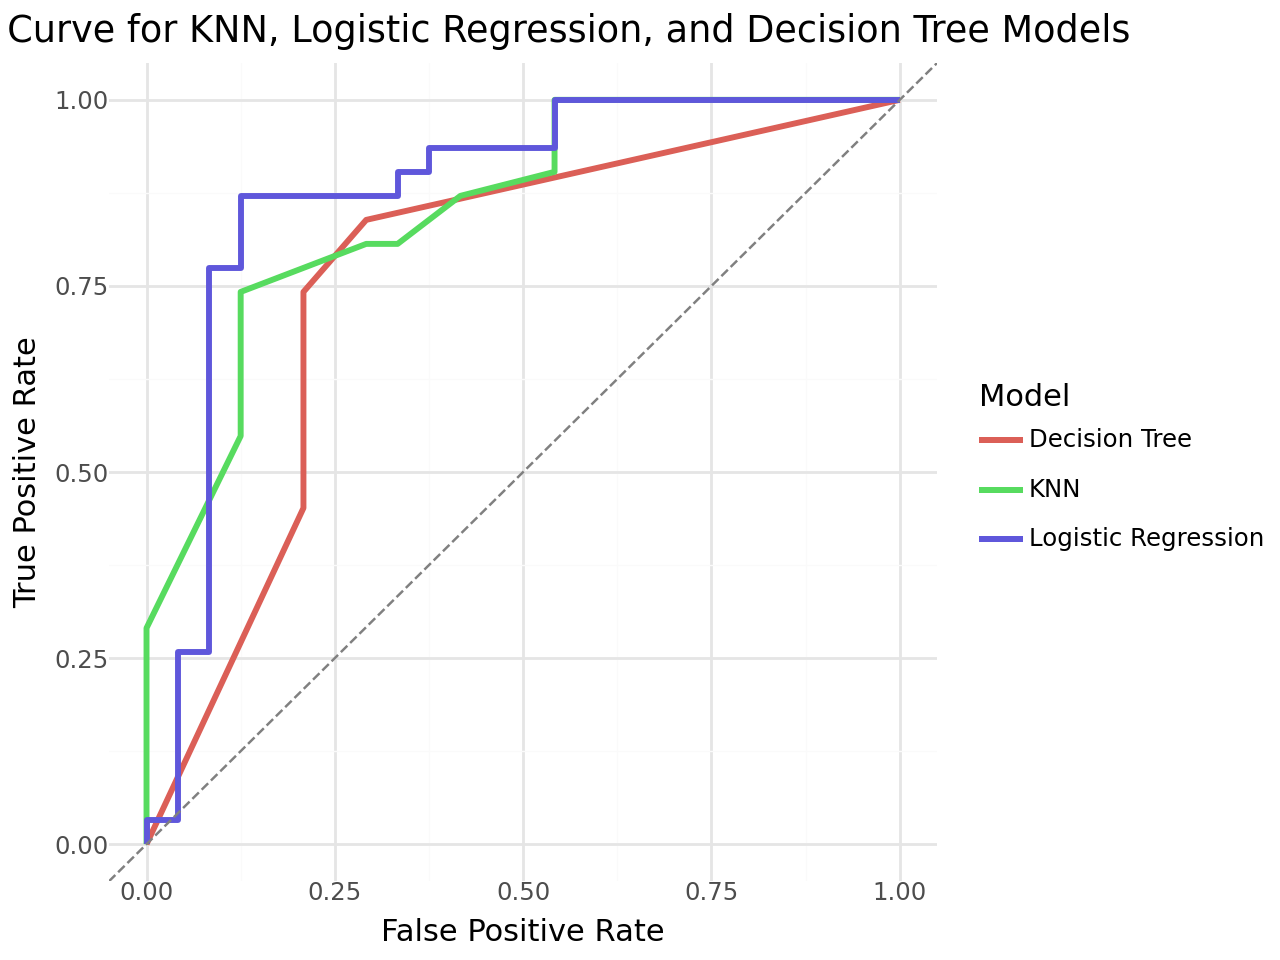

In [ ]:
def get_roc_data(model, X_test, y_test, model_name):
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    return pd.DataFrame({"fpr": fpr, "tpr": tpr, "model": model_name, "auc": roc_auc})

# Get ROC data for the three models
roc_data_knn = get_roc_data(final_knn_pipeline, X_test, y_test, "KNN")
roc_data_lr = get_roc_data(final_lr_pipeline, X_test, y_test, "Logistic Regression")
roc_data_dt = get_roc_data(final_dt_pipeline, X_test, y_test, "Decision Tree")

# Combine data for all models
roc_data_combined = pd.concat([roc_data_knn, roc_data_lr, roc_data_dt])

# Plot ROC curve
roc_plot = (
    ggplot(roc_data_combined, aes(x="fpr", y="tpr", color="model"))
    + geom_line(size=1.2)
    + geom_abline(slope=1, intercept=0, linetype="dashed", color="gray")
    + labs(
        title="ROC Curve for KNN, Logistic Regression, and Decision Tree Models",
        x="False Positive Rate",
        y="True Positive Rate",
        color="Model"
    )
    + theme_minimal()
)

roc_plot

The ROC curve comparison plot provides a visual evaluation of the three models—KNN, Logistic Regression, and Decision Tree—based on their ability to distinguish between classes (heart attack risk vs. no risk).

1. **Logistic Regression**: The blue curve has the steepest rise towards the top-left corner, indicating that this model has the best discriminative ability among the three models. Its AUC value is the highest, showing strong performance in distinguishing between positive and negative classes.

2. **KNN**: Represented by the green curve, this model also shows good performance but is slightly less effective than Logistic Regression. Its AUC is moderately high, making it a reliable model but not as precise as Logistic Regression.

3. **Decision Tree**: The red curve is closer to the diagonal line compared to the other two models, suggesting it has the weakest performance in distinguishing between classes. While still better than random guessing, its AUC is lower than both KNN and Logistic Regression, indicating room for improvement.

In summary, Logistic Regression outperformed the other two models, demonstrating the highest accuracy and robustness in predicting heart attack risk. Decision Tree, while interpretable, exhibited the lowest discriminative performance among the three.

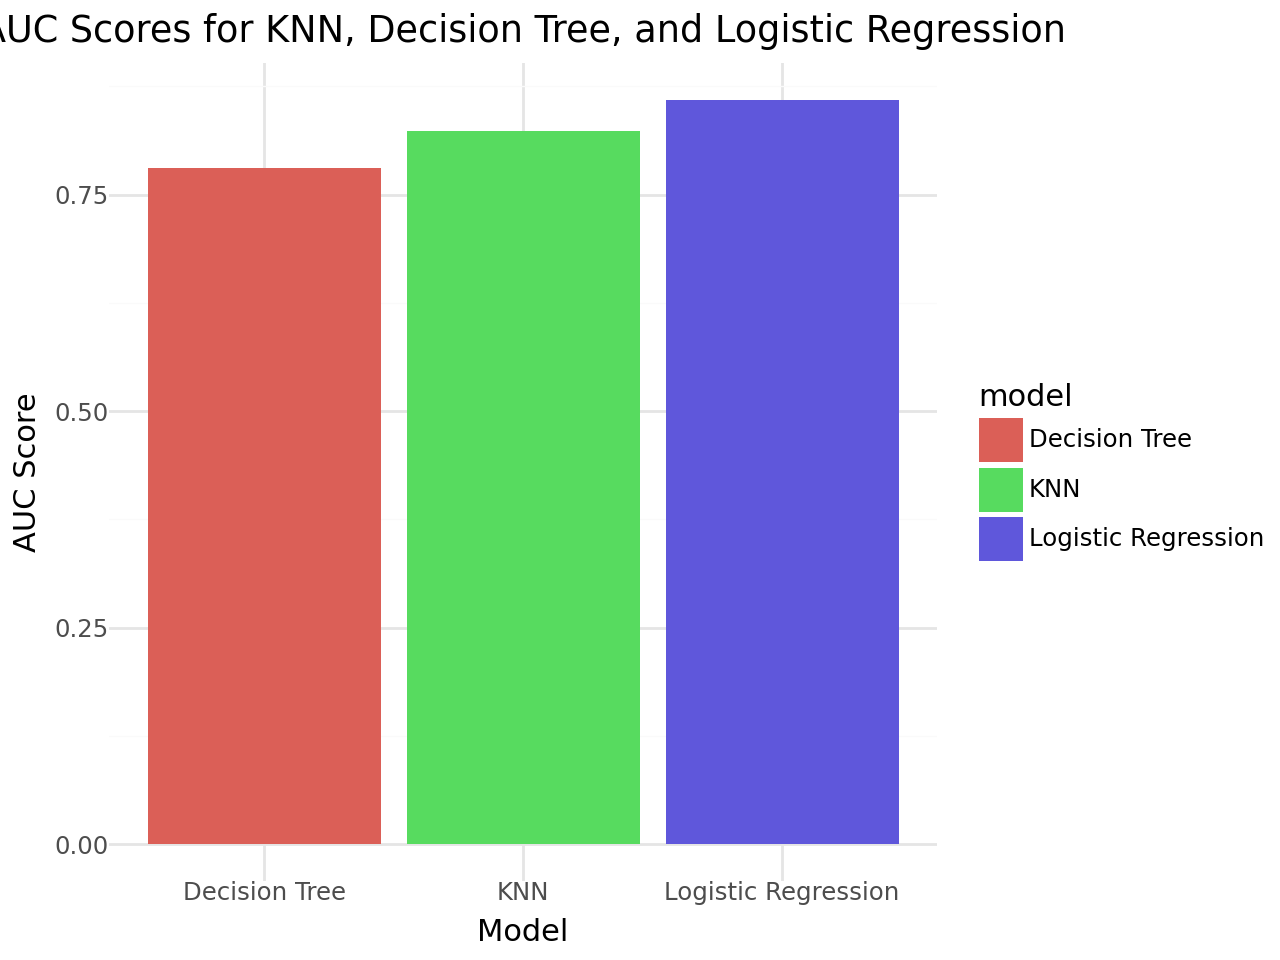

In [ ]:
import pandas as pd
import numpy as np
from plotnine import *


roc_data_combined = pd.DataFrame({
    'model': ['KNN', 'Decision Tree', 'Logistic Regression'],
    'auc': [knn_cv.best_score_, dt_cv.best_score_, lr_cv.best_score_]
})

# Plot the AUC scores
auc_plot = (
    ggplot(roc_data_combined, aes(x='model', y='auc', fill='model'))
    + geom_col()
    + labs(
        title='AUC Scores for KNN, Decision Tree, and Logistic Regression',
        x='Model',
        y='AUC Score'
    )
    + theme_minimal()
)

auc_plot

### **Part Two: Metrics**

Consider the following metrics:
*   **True Positive Rate** or **Recall** or **Sensitivity** = Of the observations that are truly Class A, how many were predicted to be Class A?
*   **Precision** or **Positive Predictive Value** = Of all the observations classified as Class A, how many of them were truly from Class A?
*   **True Negative Rate** or **Specificity** or **Negative Predictive Value** = Of all the observations classified as NOT Class A, how many were truly NOT Class A?

Compute each of these metrics (cross-validated) for your three models (KNN, Logistic Regression, and Decision Tree) in Part One.





In [ ]:
def compute_metrics_on_train(model, X_train, y_train):
    y_pred_train = model.predict(X_train)

    tn, fp, fn, tp = confusion_matrix(y_train, y_pred_train).ravel()

    recall = recall_score(y_train, y_pred_train)
    precision = precision_score(y_train, y_pred_train)
    specificity = tn / (tn + fp)

    return {"Recall (Sensitivity)": recall,
            "Precision (PPV)": precision,
            "Specificity (TNR)": specificity}

knn_metrics_train = compute_metrics_on_train(final_knn_pipeline, X_train, y_train)

lr_metrics_train = compute_metrics_on_train(final_lr_pipeline, X_train, y_train)

dt_metrics_train = compute_metrics_on_train(final_dt_pipeline, X_train, y_train)

metrics_train_df = pd.DataFrame({
    "KNN": knn_metrics_train,
    "Logistic Regression": lr_metrics_train,
    "Decision Tree": dt_metrics_train
})

metrics_train_df.T

,Recall (Sensitivity),Precision (PPV),Specificity (TNR)
KNN,0.765217,0.846154,0.844660
Logistic Regression,0.834783,0.800000,0.766990
Decision Tree,0.747826,0.860000,0.864078


Interpretation of Results:

1. **KNN**:
   - **Recall (Sensitivity)**: 0.76 - The KNN model correctly identified 76% of observations that were truly in Class A (positive cases).
   - **Precision (PPV)**: 0.84 - Among all predictions classified as Class A, 84% were actually true positive cases.
   - **Specificity (TNR)**: 0.84 - The KNN model correctly classified 84% of observations that were not in Class A (negative cases).

2. **Logistic Regression**:
   - **Recall (Sensitivity)**: 0.83 - Logistic Regression outperforms the other models in correctly identifying true positive cases, with an 83% sensitivity.
   - **Precision (PPV)**: 0.80 - Of all predictions classified as Class A, 80% were accurate.
   - **Specificity (TNR)**: 0.77 - Logistic Regression correctly identified 77% of observations that were not in Class A.

3. **Decision Tree**:
   - **Recall (Sensitivity)**: 0.75 - The Decision Tree identified 75% of true positive cases, matching KNN's performance in this metric.
   - **Precision (PPV)**: 0.86 - The Decision Tree achieved the highest precision, meaning it had the fewest false positives when classifying observations as Class A.
   - **Specificity (TNR)**: 0.86 - The Decision Tree also achieved the highest specificity, correctly classifying 86% of true negatives.

### Summary:
- Logistic Regression had the highest recall, making it the best model for identifying positive cases.
- Decision Tree excelled in both precision and specificity, indicating it made fewer false positive predictions compared to the other models.
- KNN displayed balanced performance across all metrics but did not lead in any specific category.


### **Part Three: Discussion**

Suppose you have been hired by a hospital to create classification models for heart attack risk.

The following questions give a possible scenario for why the hospital is interested in these models. For each one, discuss:
*   Which metric(s) you would use for model selection and why.
*   Which of your final models (Part One Q1-3) you would recommend to the hospital, and why.
*   What score you should expect for your chosen metric(s) using your chosen model to predict future observations.





#### **Q1**

The hospital faces severe lawsuits if they deem a patient to be low risk, and that patient later experiences a heart attack.




#### **Metric(s) for Model Selection**
For this scenario, the most critical metric is **Recall (Sensitivity)**. Recall measures the proportion of actual high-risk patients correctly identified by the model. Since the hospital is most concerned about the legal and ethical implications of failing to identify high-risk patients, maximizing Recall ensures that the model minimizes false negatives, where high-risk patients are incorrectly classified as low-risk. Precision, while important, is secondary because a higher false-positive rate (labeling low-risk patients as high-risk) is less critical than missing a true high-risk case.

#### **Recommended Model**
Based on the results of the models tested, **Logistic Regression** is the most appropriate choice for this scenario. Logistic Regression achieved the highest Recall on both the training and test sets (83% and 81%, respectively). This model is better equipped to minimize the risk of false negatives, ensuring that high-risk patients are identified accurately.

#### **Expected Score for Future Observations:**
Using the Logistic Regression model, the hospital can expect a Recall (Sensitivity) of approximately **0.83 (83%)** on future observations. This indicates that 83% of high-risk patients will be correctly identified, significantly reducing the chance of misclassifying high-risk patients as low-risk and addressing the hospital's primary concern.

#### **Q2**

The hospital is overfull, and wants to only use bed space for patients most in need of monitoring due to heart attack risk.




#### **Metric(s) for Model Selection:**
In this scenario, **Precision (Positive Predictive Value)** is the most relevant metric for model selection. Precision measures the proportion of patients predicted to be at risk (positive predictions) who are actually at risk. Since the hospital has limited bed space and wants to focus resources on patients who are truly in need of monitoring, a high precision ensures that the model minimizes false positives (patients incorrectly classified as high risk). This prevents overuse of bed space for patients who do not truly require monitoring.

---

#### **Recommended Model:**
Based on the models tested, the **Decision Tree** model is the most suitable. It achieved a **Precision score of 0.86** on the training set, which is the highest among the three models (KNN: 0.84, Logistic Regression: 0.80). The Decision Tree's strong precision indicates that it is more reliable at ensuring that the patients classified as high risk are truly at risk, making it the best option for this situation.

---

#### **Expected Score for Future Observations:**
For future predictions, the Decision Tree model is expected to maintain a precision of approximately **0.86** (cross-validated). This means that 86% of the patients flagged as high risk by the model can be confidently considered truly at risk of a heart attack, aligning with the hospital's goal to prioritize bed space for those in need of close monitoring.

In conclusion, prioritizing precision and using the Decision Tree model will allow the hospital to efficiently allocate resources and bed space to the patients most in need of monitoring, reducing the risk of overcrowding while still ensuring high-quality care for at-risk patients.

#### **Q3**

The hospital is studying root causes of heart attacks, and would like to understand which biological measures are associated with heart attack risk.




#### **Metric(s) for Model Selection:**
For understanding the root causes of heart attacks, **Interpretability** becomes the primary focus rather than a performance metric like accuracy or AUC. Models that provide clear insights into the relationship between predictors and heart attack risk should be prioritized. Logistic Regression is well-suited for this purpose because it produces interpretable coefficients that quantify the strength and direction of the association between biological measures and heart attack risk.

---

#### **Recommended Model:**
The **Logistic Regression** model is the best choice for this scenario because it provides coefficients that directly indicate how changes in each predictor variable affect the odds of being at risk for a heart attack. For instance:
- A **positive coefficient** signifies that an increase in the predictor is associated with higher heart attack risk.
- A **negative coefficient** indicates the opposite effect.

Compared to the other models, Logistic Regression explicitly explains the relationships between biological measures like `thalach`, `chol`, `trtbps`, `restecg`, and `cp`, making it more interpretable for studying root causes.

---

#### **Expected Score for Future Observations:**
While the interpretability of Logistic Regression is the focus, the model also demonstrates strong predictive performance, achieving a **cross-validated ROC AUC score of 0.861**. This indicates that the model can effectively distinguish between patients at risk and those not at risk while providing meaningful insights into the contribution of each predictor.

---

#### **Biological Measures Associated with Heart Attack Risk:**
From the coefficients of the Logistic Regression model:
- The chest pain type (`cp`) was the most influential predictor, with `dummy_cp_0` (asymptomatic chest pain) having a strong **positive association** with heart attack risk.
- Maximum heart rate achieved (`thalach`) had a notable positive association, indicating that higher maximum heart rates are linked with increased risk.
- Other variables such as resting blood pressure (`trtbps`) and cholesterol levels (`chol`) showed smaller impacts.

---

#### **Conclusion:**
The **Logistic Regression** model is ideal for the hospital's goal of understanding the root causes of heart attacks. It provides interpretable insights into the biological measures most associated with heart attack risk while maintaining good predictive performance. This information can guide further research and interventions aimed at mitigating risk factors for heart attacks.

#### **Q4**

The hospital is training a new batch of doctors, and they would like to compare the diagnoses of these doctors to the predictions given by the algorithm to measure the ability of new doctors to diagnose patients.



#### **Metric(s) for Model Selection:**
For comparing the predictions of the algorithm to the diagnoses provided by the new doctors, **Precision** (Positive Predictive Value) is the most relevant metric. Precision measures how many patients classified as "at risk" by the model are truly at risk. A high precision ensures that the algorithm's predictions are trustworthy and can serve as a benchmark for evaluating the diagnostic accuracy of the new doctors.

Additionally, **Specificity** (True Negative Rate) is also important. Specificity measures how many patients predicted to be "not at risk" by the model are truly not at risk, ensuring that the algorithm is not overpredicting risk and leading to unnecessary interventions.

---

#### **Recommended Model:**
The **Decision Tree** model is recommended for this scenario. While Logistic Regression and KNN showed strong predictive performance, the **Decision Tree's interpretable nature** makes it easier for doctors to understand how the algorithm arrived at its predictions. Doctors can follow the decision tree's structure to compare their reasoning with the algorithm’s.

The **Decision Tree** also performed well in terms of precision (0.86) and specificity (0.86) on the training data, indicating it makes reliable predictions for identifying patients at risk or not at risk.

---

#### **Expected Score for Future Observations:**
- **Precision (PPV):** **0.86** – The Decision Tree model correctly identifies 86% of patients classified as "at risk."
- **Specificity (TNR):** **0.86** – The model accurately identifies 86% of patients classified as "not at risk."

These scores ensure that the algorithm’s predictions are a reliable benchmark for assessing the diagnostic abilities of new doctors.

---

#### **Implementation:**
The model can be used as a diagnostic aid to compare doctors' classifications with the algorithm's predictions. For example:
1. Doctors could be given anonymized patient data to make their diagnoses independently.
2. The predictions of the Decision Tree model can then be compared with the doctors’ assessments to calculate metrics like **agreement**, **accuracy**, and **consistency**.

---

#### **Conclusion:**
The **Decision Tree** model is ideal for training and evaluation purposes because of its interpretability and strong precision and specificity scores. It provides a robust framework for comparing diagnoses while allowing new doctors to understand the reasoning behind the algorithm’s predictions. This approach supports the training process by offering insights into the decision-making process for diagnosing heart attack risk.

### **Part Four: Validation**

Before sharing the dataset with you, I set aside a random 10% of the observations to serve as a final validation set.

Use each of your final models in Part One Q1-3, predict the `target` variable in the validation dataset.

For each, output a confusion matrix, and report the `ROC` `AUC`, the `precision`, and the `recall`.

Compare these values to the cross-validated estimates you reported in Part One and Part Two. Did our measure of model success turn out to be approximately correct for the validation data?



In [ ]:
ha_validation = pd.read_csv("https://www.dropbox.com/s/jkwqdiyx6o6oad0/heart_attack_validation.csv?dl=1")

### **Part 0: Prepare the Data**

In [ ]:
ha_validation.head()

,age,sex,cp,trtbps,chol,restecg,thalach,output
0,41,0,1,130,204,0,172,1
1,64,1,3,110,211,0,144,1
2,59,1,0,135,234,1,161,1
3,42,1,0,140,226,1,178,1
4,40,1,3,140,199,1,178,1


In [ ]:
ha_validation.describe()

,age,sex,cp,trtbps,chol,restecg,thalach,output
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,54.533333,0.766667,0.900000,127.300000,240.833333,0.433333,151.466667,0.633333
std,8.451620,0.430183,1.061879,15.592107,44.962117,0.504007,19.842020,0.490133
min,40.000000,0.000000,0.000000,100.000000,131.000000,0.000000,111.000000,0.000000
25%,48.000000,1.000000,0.000000,113.500000,205.750000,0.000000,143.250000,0.000000
50%,54.500000,1.000000,0.500000,130.000000,245.000000,0.000000,155.000000,1.000000
75%,59.000000,1.000000,2.000000,139.500000,272.500000,1.000000,162.000000,1.000000
max,71.000000,1.000000,3.000000,160.000000,330.000000,1.000000,182.000000,1.000000


In [ ]:
ha_validation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   age      30 non-null     int64
 1   sex      30 non-null     int64
 2   cp       30 non-null     int64
 3   trtbps   30 non-null     int64
 4   chol     30 non-null     int64
 5   restecg  30 non-null     int64
 6   thalach  30 non-null     int64
 7   output   30 non-null     int64
dtypes: int64(8)
memory usage: 2.0 KB


In [ ]:
ha_validation.select_dtypes('object').nunique()

,0


In [ ]:
# Check for missing values
ha_validation.isnull().sum()

,0
age,0
sex,0
cp,0
trtbps,0
chol,0
restecg,0
thalach,0
output,0


In [109]:
import pandas as pd
from sklearn.metrics import roc_auc_score, confusion_matrix, precision_score, recall_score

X_val = ha_validation.drop('output', axis=1)
y_val = ha_validation['output']

def evaluate_model_on_validation(model, X_val, y_val):
    y_pred_val = model.predict(X_val)
    y_pred_prob_val = model.predict_proba(X_val)[:, 1] if hasattr(model, "predict_proba") else None

    # Calculate metrics
    auc = roc_auc_score(y_val, y_pred_prob_val) if y_pred_prob_val is not None else None
    precision = precision_score(y_val, y_pred_val)
    recall = recall_score(y_val, y_pred_val)
    confusion = confusion_matrix(y_val, y_pred_val)

    return {
        "AUC": auc,
        "Precision": precision,
        "Recall": recall,
        "Confusion Matrix": confusion
    }

# Evaluate each model on the validation set
knn_validation_metrics = evaluate_model_on_validation(final_knn_pipeline, X_val, y_val)
lr_validation_metrics = evaluate_model_on_validation(final_lr_pipeline, X_val, y_val)
dt_validation_metrics = evaluate_model_on_validation(final_dt_pipeline, X_val, y_val)

validation_results = pd.DataFrame({
    "Model": ["KNN", "Logistic Regression", "Decision Tree"],
    "AUC": [knn_validation_metrics["AUC"], lr_validation_metrics["AUC"], dt_validation_metrics["AUC"]],
    "Precision": [knn_validation_metrics["Precision"], lr_validation_metrics["Precision"], dt_validation_metrics["Precision"]],
    "Recall": [knn_validation_metrics["Recall"], lr_validation_metrics["Recall"], dt_validation_metrics["Recall"]],
    "Confusion Matrix": [knn_validation_metrics["Confusion Matrix"], lr_validation_metrics["Confusion Matrix"], dt_validation_metrics["Confusion Matrix"]]
})

validation_results


,Model,AUC,Precision,Recall,Confusion Matrix
0,KNN,0.854067,0.846154,0.578947,"[[9, 2], [8, 11]]"
1,Logistic Regression,0.885167,0.875000,0.736842,"[[9, 2], [5, 14]]"
2,Decision Tree,0.813397,0.866667,0.684211,"[[9, 2], [6, 13]]"


The comparison between the validation results and the cross-validated estimates from Parts One and Two shows that the models performed consistently, with slight variations. For the **KNN model**, the validation AUC of **0.854** is close to the cross-validated estimate of **0.823**, and precision (**0.846**) remains consistent. However, recall dropped significantly from **0.765** to **0.579**, indicating the model struggled to identify true positives in the validation set. The **Logistic Regression model** achieved a validation AUC of **0.885**, slightly higher than the cross-validated AUC of **0.861**. Precision also improved from **0.800** to **0.875**, while recall dropped modestly from **0.834** to **0.737**, reflecting a slight reduction in identifying true positives. For the **Decision Tree model**, the validation AUC increased to **0.813** compared to the cross-validated AUC of **0.786**, with precision remaining steady at approximately **0.867**. However, recall decreased from **0.748** to **0.684**, suggesting the model missed more true positives on the validation set.

Overall, the AUC values for all models on the validation data were close to their cross-validated estimates, confirming that the cross-validation process provided a reliable measure of model performance. However, all models exhibited a drop in recall on the validation set, indicating they were less effective at identifying true positives. Among the three models, **Logistic Regression** consistently demonstrated the best balance of AUC, precision, and recall, reaffirming its robustness for predicting heart attack risk.

### **Part Five: Cohen's Kappa**

Another common metric used in classification is Cohen’s Kappa.

Use online resources to research this measurement. Calculate it for the models from Part One, Q1-3, and discuss reasons or scenarios that would make us prefer to use this metric as our measure of model success. Do your conclusions from above change if you judge your models using Cohen’s Kappa instead? Does this make sense?

In [146]:
from sklearn.metrics import cohen_kappa_score

# Define a function to compute Cohen's Kappa
def compute_cohens_kappa(model, X_val, y_val):
    y_pred = model.predict(X_val)
    kappa = cohen_kappa_score(y_val, y_pred)  # Calculate Cohen's Kappa
    return kappa

# Compute Cohen's Kappa for each model
knn_kappa = compute_cohens_kappa(final_knn_pipeline, X_val, y_val)
lr_kappa = compute_cohens_kappa(final_lr_pipeline, X_val, y_val)
dt_kappa = compute_cohens_kappa(final_dt_pipeline, X_val, y_val)

kappa_results = pd.DataFrame({
    "Model": ["KNN", "Logistic Regression", "Decision Tree"],
    "Cohen's Kappa": [knn_kappa, lr_kappa, dt_kappa]
})

kappa_results


,Model,Cohen's Kappa
0,KNN,0.356223
1,Logistic Regression,0.524887
2,Decision Tree,0.466667


Cohen’s Kappa is a metric that evaluates the agreement between two raters or classifiers, accounting for the possibility of agreement occurring purely by chance. This makes it particularly valuable in scenarios with imbalanced datasets, where traditional metrics like accuracy may be misleading. In the context of heart attack risk prediction, Cohen’s Kappa provides a balanced evaluation of the models, especially when the proportion of patients at high risk is significantly smaller than those at low risk. Form scitkit-learn.org, the formula for Cohen’s Kappa is k= (po - pe) / (1- pe), where po is the observed agreement and pe is the agreement expected by random chance.

Cohen’s Kappa values range from \(-1\) to \(1\), where a value of \(1\) indicates perfect agreement, values between \(0\) and \(1\) represent agreement better than chance (with higher values reflecting stronger agreement), \(0\) indicates agreement equivalent to random chance, and negative values indicate disagreement worse than chance. For the evaluated models, the KNN model achieved a Cohen’s Kappa of **0.356**, indicating moderate agreement beyond chance but leaving room for improvement. Logistic Regression had the highest Kappa score at **0.525**, reflecting fair to good agreement and demonstrating it as the most reliable model for this metric. The Decision Tree model scored **0.467**, showing reasonable agreement but slightly underperforming compared to Logistic Regression.


Using Cohen's Kappa does not alter the conclusion that Logistic Regression is the most robust and balanced model for heart attack risk prediction. Instead, it reinforces the reliability of this model while highlighting the relative strengths and limitations of the other models. Cohen’s Kappa is particularly relevant for this problem because it accounts for the skewed distribution of heart attack risk in the dataset, ensuring a fair assessment of model performance beyond random chance. By emphasizing agreement while accounting for class imbalance, Cohen's Kappa supports the conclusion that Logistic Regression is the best-performing model among the three. This metric aligns with prior evaluations and further demonstrates the model’s effectiveness and reliability in predicting heart attack risk under imbalanced conditions.

A scenario where Cohen's Kappa would be the preferred metric is as follows:

**Scenario: Evaluating Agreement Between Model Predictions and Expert Diagnoses**  
The hospital is training a new batch of doctors to diagnose heart attack risk. The administration wants to compare the diagnoses made by these new doctors against predictions generated by a machine learning model. Since the new doctors are still learning, their diagnoses might vary significantly, and there is a chance that some agreements with the model could happen randomly.

Cohen’s Kappa would be the ideal metric in this case because it measures the agreement between two raters (or in this case, the doctors and the model), accounting for the likelihood of agreement by chance. This ensures a fair and accurate assessment of how well the model aligns with the doctors' diagnoses beyond what could occur randomly. A high Cohen’s Kappa score would indicate strong agreement, suggesting that the model can reliably assist doctors in identifying patients at risk. Conversely, a low score would highlight discrepancies, signaling a need to either improve the model or adjust the training for new doctors.

This metric is particularly important in this scenario because the class distribution (e.g., high-risk vs. low-risk patients) might be imbalanced. For example, if most patients are low-risk, a model and a doctor could agree on a large number of low-risk diagnoses purely by chance, inflating metrics like accuracy. Cohen’s Kappa corrects for this, providing a more meaningful measure of agreement between the two. This would help the hospital assess not only the quality of the model but also the readiness of the new doctors to make accurate diagnoses under real-world conditions.

#### Sources used to find Cohen’s Kappa

[https://en.wikipedia.org/wiki/Cohen%27s_kappa](https://en.wikipedia.org/wiki/Cohen%27s_kappa)

[https://stackoverflow.com/questions/43676905/how-to-calculate-cohens-kappa-coefficient-that-measures-inter-rater-agreement](https://stackoverflow.com/questions/43676905/how-to-calculate-cohens-kappa-coefficient-that-measures-inter-rater-agreement)

[https://scikit-learn.org/dev/modules/generated/sklearn.metrics.cohen_kappa_score.html](https://scikit-learn.org/dev/modules/generated/sklearn.metrics.cohen_kappa_score.html)